In [1]:
import math, random

import gym
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
import torch.autograd as autograd 
import torch.nn.functional as F
import gym_Aircraft

In [2]:
from IPython.display import clear_output
import matplotlib.pyplot as plt
%matplotlib inline
USE_CUDA = torch.cuda.is_available()
Variable = lambda *args, **kwargs: autograd.Variable(*args, **kwargs).cuda() if USE_CUDA else autograd.Variable(*args, **kwargs)

In [3]:
from collections import deque

class ReplayBuffer(object):
    def __init__(self, capacity):
        self.buffer = deque(maxlen=capacity)
    
    def push(self, state, action, reward, next_state, done):
        state      = np.expand_dims(state, 0)
        next_state = np.expand_dims(next_state, 0)
            
        self.buffer.append((state, action, reward, next_state, done))
    
    def sample(self, batch_size):
        state, action, reward, next_state, done = zip(*random.sample(self.buffer, batch_size))
        return np.concatenate(state), action, reward, np.concatenate(next_state), done
    
    def __len__(self):
        return len(self.buffer)

In [4]:
env = gym.make("acav-v0")

In [5]:
epsilon_start = 1.0
epsilon_final = 0.01
epsilon_decay = 500

epsilon_by_frame = lambda frame_idx: epsilon_final + (epsilon_start - epsilon_final) * math.exp(-1. * frame_idx / epsilon_decay)

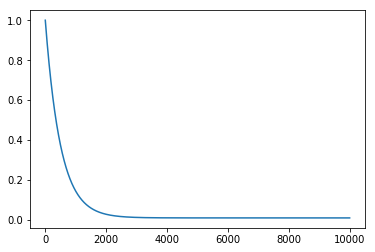

In [6]:
plt.plot([epsilon_by_frame(i) for i in range(10000)])

In [7]:
class DQN(nn.Module):
    def __init__(self, num_inputs, num_actions):
        super(DQN, self).__init__()
        
        self.layers = nn.Sequential(
            nn.Linear(env.observation_space.shape[0], 40),
            nn.ReLU(),
            nn.Linear(40, 40),
            nn.ReLU(),
            nn.Linear(40, 40),
            nn.ReLU(),
            nn.Linear(40, 40),
            nn.ReLU(),
            nn.Linear(40, 40),
            nn.ReLU(),
            nn.Linear(40, 40),
            nn.ReLU(),
            nn.Linear(40, 40),
            nn.ReLU(),
            nn.Linear(40, env.action_space.n)
        )
        
    def forward(self, x):
        return self.layers(x)
    
    
    def act(self, state, epsilon):
        if random.random() > epsilon:
            state   = Variable(torch.FloatTensor(state).unsqueeze(0), volatile=True)
            q_value = self.forward(state)
            with torch.no_grad():
                action  = q_value.max(1)[1].data[0]
        else:
            action = random.randrange(env.action_space.n)
        return action

In [8]:
model = DQN(env.observation_space.shape[0], env.action_space.n)

if USE_CUDA:
    model = model.cuda()
    
optimizer = optim.Adam(model.parameters())

replay_buffer = ReplayBuffer(1000)

In [9]:
def compute_td_loss(batch_size):
    state, action, reward, next_state, done = replay_buffer.sample(batch_size)

    state      = Variable(torch.FloatTensor(np.float32(state)))
    next_state = Variable(torch.FloatTensor(np.float32(next_state)), volatile=True)
    action     = Variable(torch.LongTensor(action))
    reward     = Variable(torch.FloatTensor(reward))
    done       = Variable(torch.FloatTensor(done))

    q_values      = model(state)
    next_q_values = model(next_state)

    q_value          = q_values.gather(1, action.unsqueeze(1)).squeeze(1)
    next_q_value     = next_q_values.max(1)[0]
    expected_q_value = reward + gamma * next_q_value * (1 - done)
    
    loss = (q_value - Variable(expected_q_value.data)).pow(2).mean()
        
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    return loss

In [10]:
num_epi = 100000
batch_size = 32

gamma      = 0.99
res_hdotcmd=[]


losses = []

all_rewards = []

episode_reward = 0

state = env.reset()
for epi in range(1, num_epi + 1):
    
    epsilon = epsilon_by_frame(epi)
    action = model.act(state, epsilon)
    
    next_state, reward, done, res = env.step(action)
    replay_buffer.push(state, action, reward, next_state, done)
    
    state = next_state
    episode_reward += reward
    
    res_hdotcmd.append(res[0])
    
    if done:
        state = env.reset()
        all_rewards.append(episode_reward)
        episode_reward = 0
        
    if len(replay_buffer) > batch_size:
        loss = compute_td_loss(batch_size)
        losses.append(loss.item())
        
#     if epi % 200 == 0:
#         plt.plot(np.arange(epi),losses)
#         plt.plot(np.arange(epi), all_rewards)

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:5: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  """


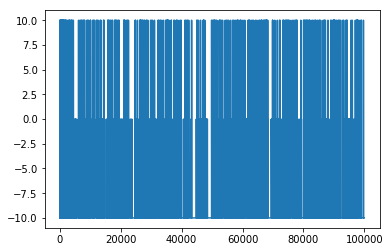

In [11]:
plt.plot(res_hdotcmd)

In [12]:
len(all_rewards)

20000

In [13]:
len(losses)

99968

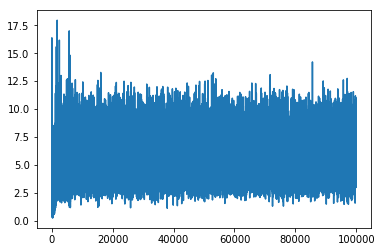

In [14]:
plt.plot(losses)

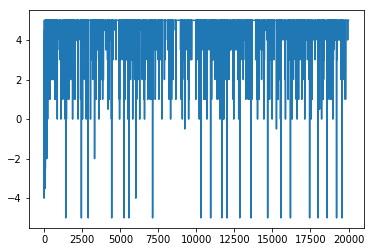

In [15]:
plt.plot(all_rewards)